In [66]:

# import packages 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from tabulate import tabulate

import re
#from wordcloud import WordCloud, STOPWORDS
from collections import Counter

import matplotlib.pyplot as plt




import os
cwd = os.getcwd()
print(cwd)


# create color scheme for visualizations
# Define Dermologica brand colors
colors = ['#55b1e5', '#0085ca', '#0067a9', '#5c5d5d']
sns.set_palette('deep', desat=0.6)
sns.set_style('darkgrid', {'axes.linewidth': 2, 'axes.edgecolor': 'black'}) # sets border
sns.set_style('darkgrid', {'axes.linewidth': 2, 'axes.edgecolor': 'black'}) # sets style
plt.rcParams['figure.figsize'] = [8, 6] #figure size

# read the CSV file
original_df = pd.read_csv('C:/Users/ab3245/Downloads/Ulta Skincare Reviews.csv')


C:\Users\ab3245


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ab3245\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ab3245\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ab3245\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# create copy of original df
df = original_df.copy()
df.describe()

,Review_Upvotes,Review_Downvotes
count,4150.000000,4150.000000
mean,0.591325,0.161205
std,2.210041,0.912561
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,84.000000,35.000000


In [5]:
# Check for duplicates
print(df.duplicated().sum())

456


In [6]:

# Count the number of duplicated records of 'Review_Text'
num_duplicates = df.duplicated(subset=['Review_Text']).sum()
print(f'Total number of duplicated records based on Review_Text: {num_duplicates}')


Total number of duplicated records based on Review_Text: 489


In [7]:
# identify exact duplicate records
exact_duplicate_mask = df.duplicated(keep=False)
exact_duplicate_records = df[exact_duplicate_mask]
print(exact_duplicate_records[:100])
print(df.duplicated().sum())

                        Review_Title  \
705                          Buy it!   
706                  Amazing product   
707  Would absolutely buy this again   
708                   It's hydrating   
709                   Love this mask   
..                               ...   
800                          Buy it!   
801                  Amazing product   
802  Would absolutely buy this again   
803                   It's hydrating   
804                   Love this mask   

                                           Review_Text Verified_Buyer  \
705                    Works great for all skin types!             No   
706  This product leaves your skin looking smooth a...             No   
707  This product is wonderful! Some masks you have...             No   
708  I've used this product a few times and I haven...             No   
709  I just used my fingers and rubbed mask on clea...             No   
..                                                 ...            ...   
800     

In [8]:
# Exploratory Data Analysis
print(df.head()) 
df.describe() #numeric vars
print(df.shape)


                      Review_Title  \
0                          Perfect   
1                    You need this   
2                       Clean skin   
3                 Love This Stuff!   
4  This exfoliates very nicely and   

                                         Review_Text Verified_Buyer  \
0  Love using this on my face while in the shower...             No   
1  Even better than the daily microfoliant. I'm o...             No   
2  Enjoy this product so much ! I look forward to...             No   
3  I've never tried anything like this before and...             No   
4  This exfoliates very nicely and gives a very s...             No   

    Review_Date Review_Location  Review_Upvotes  Review_Downvotes  \
0   15 days ago     Undisclosed               0                 0   
1   27 days ago     Undisclosed               0                 0   
2  2 months ago     Undisclosed               0                 0   
3  2 months ago     Undisclosed               0                 0   

In [34]:
# check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

# remove rows with missing data
df = df.dropna()


ID                   0
Review_Title         0
Review_Text          0
Verified_Buyer       0
Review_Date          0
Review_Location      0
Review_Upvotes       0
Review_Downvotes     0
Product              0
Brand                0
Scrape_Date          0
clean_review_text    0
dtype: int64


In [9]:
# Create an ID column
# Note: this will create an additional ID var each time code runs
df.reset_index(inplace=True)
df.rename(columns={'index': 'ID'}, inplace=True)
print(df.shape) # 11 columns 


(4150, 11)


In [23]:
# define function to clean text
def clean_text(text):
    # check if the input text is a string
    if isinstance(text, str):
        
        # convert to lowercase
        text = text.lower()
      
        # replace contractions with expanded forms
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'m", " am", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ll", " will", text)
       
        # remove non-alphanumeric characters
        text = re.sub(r'[^\w\s]', ' ', text)
        # remove digits
        text = re.sub(r'\d+', ' ', text)
        
        # remove stopwords
        stop_words = set(stopwords.words('english'))
        stop_words.update(['really', 'use', 'using', 'face', 'one', 'used', 'skin', 'product', 'dermalogica', 'daily', 'microfoliant', 'superfoliant', 'thermafoliant' ]) #not helpful words
        
        # tokenize text
        text_tokens = nltk.word_tokenize(text)
        tokens_without_sw = [word for word in text_tokens if word.lower() not in stop_words]
        
        # lemmatize words
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens_without_sw]
        # join tokens back into a string
        clean_text = ' '.join(lemmatized_tokens)
        return clean_text
    else:
        return ''

In [24]:
# Assess the results of clean_text

# Select a sample of reviews
sample_reviews = df['Review_Text'].sample(n=10)

# Apply clean_text function to the sample of reviews
cleaned_reviews = sample_reviews.apply(clean_text)

In [27]:

# Print the original and cleaned reviews for comparison
for i in range(len(sample_reviews)):
    print('Original Review:\n', sample_reviews.iloc[i])
    print('Cleaned Review:\n', cleaned_reviews.iloc[i])
    print('----------------------------------------\n')


Original Review:
 This product is my new favorite! It's amazing!
Cleaned Review:
 new favorite amazing
----------------------------------------

Original Review:
 I just used my fingers and rubbed mask on clean damp skin. Left on for 5 mins and then wet fingers and rubbed it into my skin and then rinsed off. My skin was left feeling so soft and smooth and looking great. The texture of the mask has little spheres and it smells great. I would definitely recommend giving it a try!
Cleaned Review:
 finger rubbed mask clean damp left min wet finger rubbed rinsed left feeling soft smooth looking great texture mask little sphere smell great would definitely recommend giving try
----------------------------------------

Original Review:
 This really helps keep my skin smooth. Love it
Cleaned Review:
 help keep smooth love
----------------------------------------

Original Review:
 Great product for skin types in need for the resurfacing. I constantly had funny skin texture on certain days - so

In [31]:
  # create a new var of cleaned text
df['clean_review_text'] = df['Review_Text'].apply(clean_text)

In [28]:
# examine nltk stop words
SW = nltk.corpus.stopwords.words('english')
print(SW, len(SW))
# note the punctuation


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

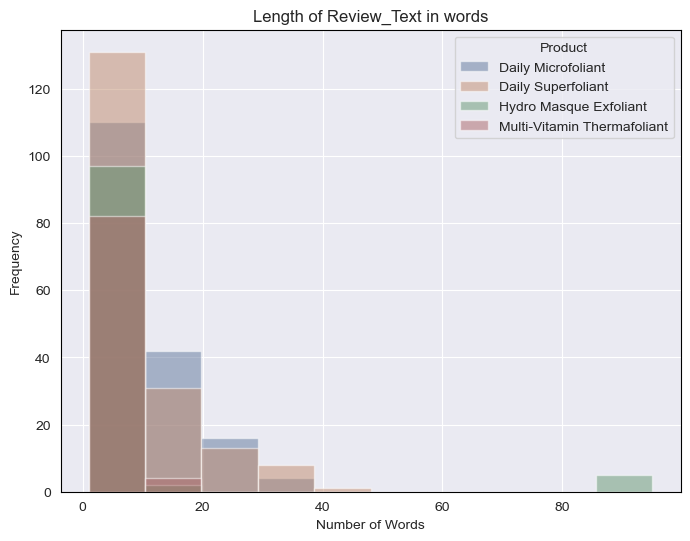

In [37]:
# Exploring length of reviews in words, grouped by product

# Split the review_text column into words and count the number of words
df['Review_Length'] = df['Review_Text'].apply(lambda x: len(x.split()))

# Group the df by product and review length and count the number of reviews
grouped_df = df.groupby(['Product', 'Review_Length'])['Review_Text'].count().reset_index()

# Pivot the DataFrame so each product is a column
pivoted_df = grouped_df.pivot(index='Review_Length', columns='Product', values='Review_Text')

# Plot a histogram for each product
pivoted_df.plot(kind='hist', alpha=0.5)
# Set the x and y axis labels
plt.title('Length of Review_Text in words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()



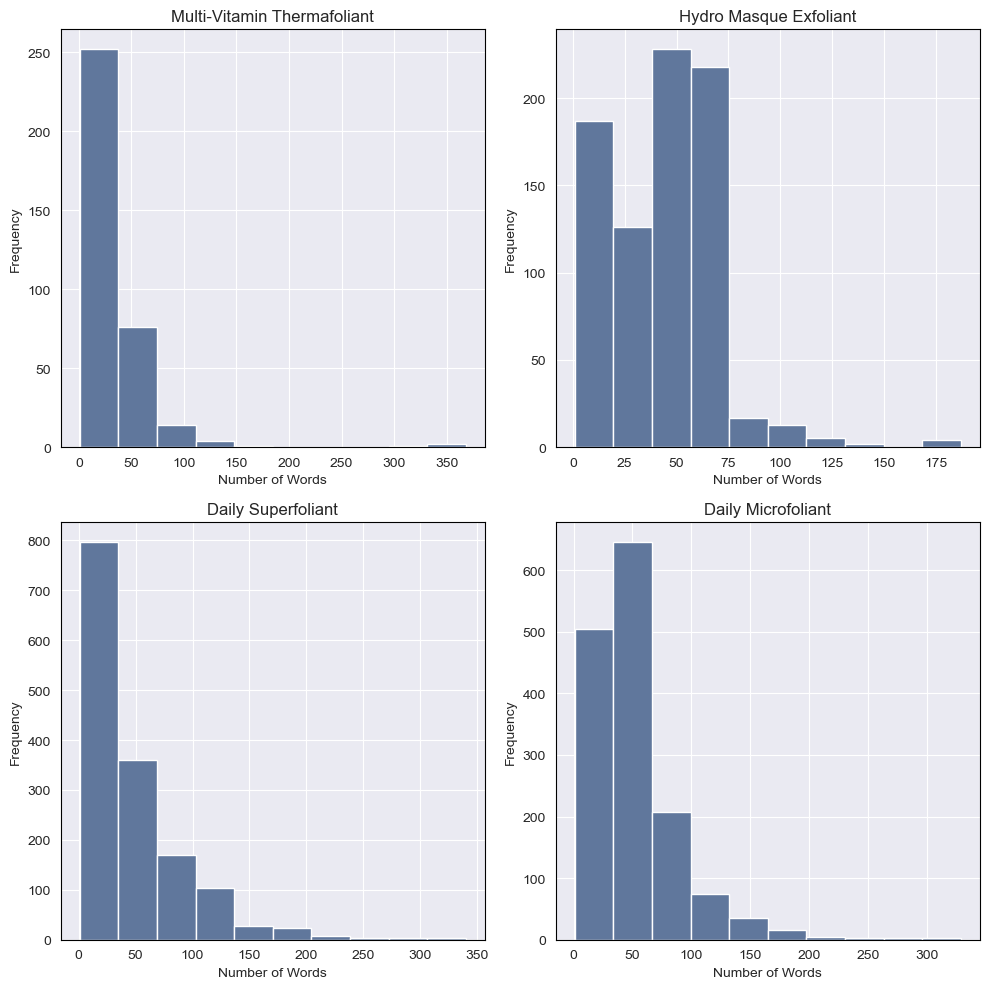

In [48]:
# Assessing review_length grouped by product - individual plots

# Split the review text into words and count the number of words
df['Review_Length'] = df['Review_Text'].apply(lambda x: len(x.split()))

# Create a list of products
products = df['Product'].unique()

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Determine the common y-axis limits based on the data
for i, product in enumerate(products):
    product_df = df[df['Product'] == product]
    min_length = min(min_length, product_df['Review_Length'].min())
    max_length = max(max_length, product_df['Review_Length'].max())
        
# Plot a histogram for each product on a different subplot
for i, product in enumerate(products):
    row = i // 2
    col = i % 2
    product_df = df[df['Product'] == product]
    axs[row, col].hist(product_df['Review_Length'])
    axs[row, col].set_title(product)
    axs[row, col].set_xlabel('Number of Words')
    axs[row, col].set_ylabel('Frequency')
 
# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()# we see the spike in hydro masque exfoliant


# hydromasque exfoliant has lengthier reviews

Text(0, 0.5, 'Number of Reviews')

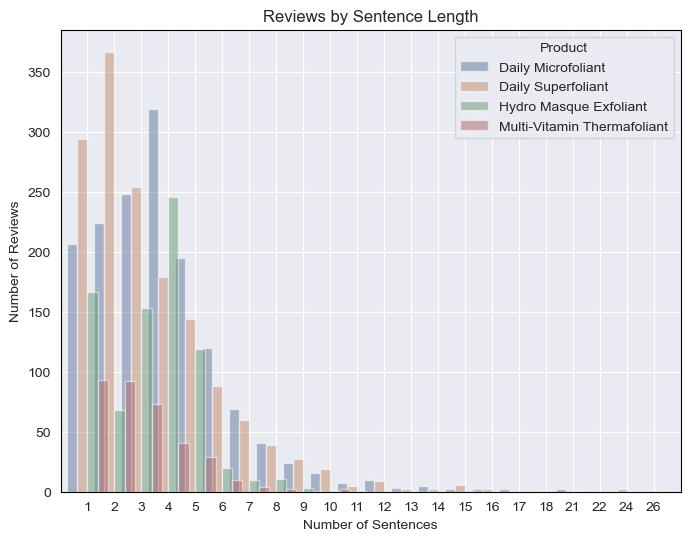

In [51]:
# Exploring sentence length of reviews

# Split the review text into sentences and count the number of sentences
df['num_sentences'] = df['Review_Text'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Group by product and count the number of reviews by length in sentences
grouped_df = df.groupby(['Product', 'num_sentences'])['Review_Text'].count().reset_index()

# Pivot the data to create a wide-form dataframe with each length as a column
pivoted_df = grouped_df.pivot(index='num_sentences', columns='Product', values='Review_Text')


# Plot a histogram of the number of reviews by length in sentences for each product
pivoted_df.plot(kind='bar', alpha=0.5, width = 1.5)

# Rotate x-axis labels
plt.xticks(rotation=0)

# Set the x and y axis labels
plt.title('Reviews by Sentence Length')
plt.xlabel('Number of Sentences')
plt.ylabel('Number of Reviews')
plt.show()


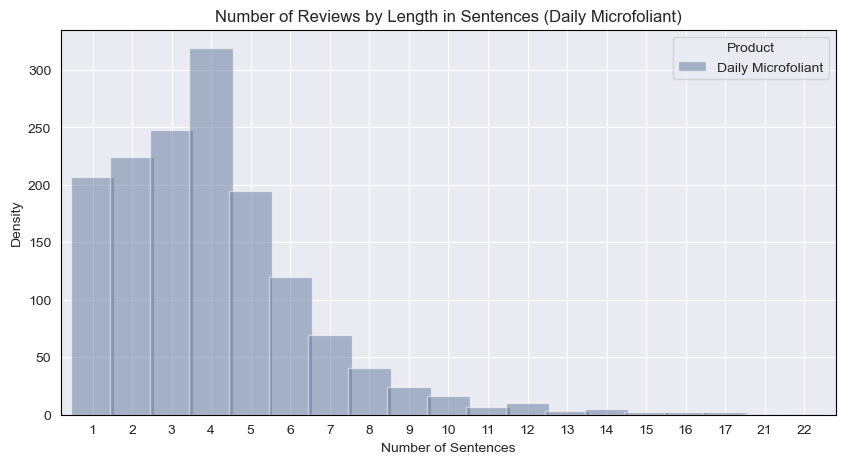

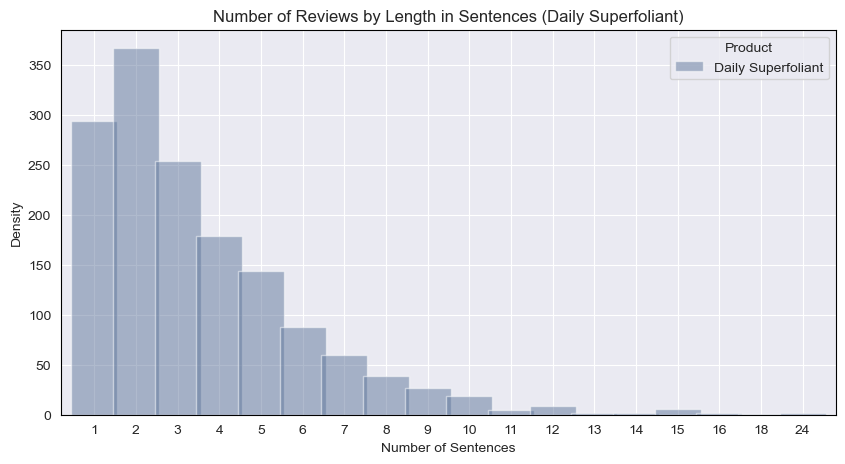

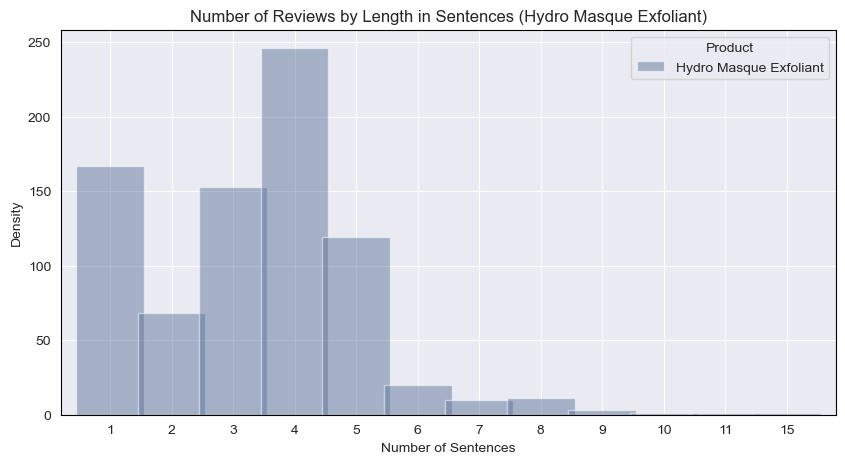

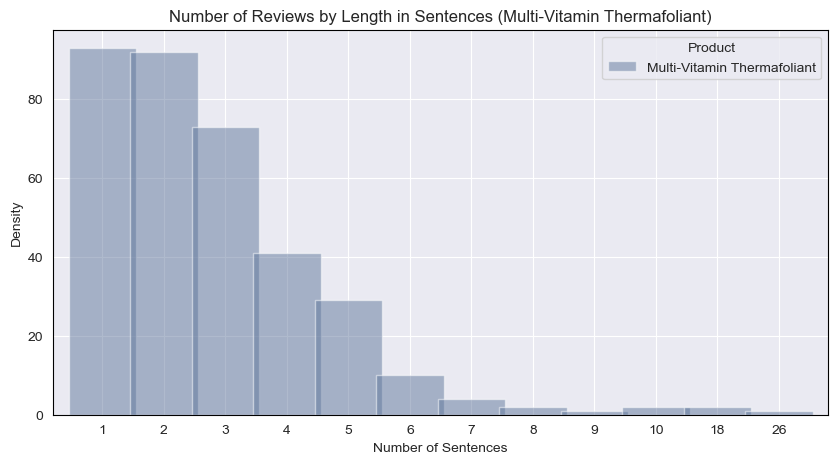

In [52]:

# Exploring number of sentences in Review_text by product

# Split the review text into sentences and count the number of sentences
df['num_sentences'] = df['Review_Text'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Group by product and count the number of reviews by length in sentences
grouped_df = df.groupby(['Product', 'num_sentences'])['Review_Text'].count().reset_index()


# Loop through each product and create a separate plot
for product in grouped_df['Product'].unique():
    # Filter the data to include only the current product
    subset_df = grouped_df[grouped_df['Product'] == product]
    
    # Pivot the data to create a wide-form dataframe with each length as a column
    pivoted_df = subset_df.pivot(index='num_sentences', columns='Product', values='Review_Text')

    # Plot a histogram of the number of reviews by length in sentences for the current product
    pivoted_df.plot(kind='bar', alpha=0.5, figsize=(10,5), width=1.1)

    # Rotate x-axis labels
    plt.xticks(rotation=0)

    # Set the x and y axis labels
    plt.title(f'Reviews by Sentence Length ({product})')
    plt.xlabel('Number of Sentences')
    plt.ylabel('Density')

    # Show plot
    plt.show()



In [ ]:

# RawText
print(len(df['Review_Text'])) #for reference

| Statistic   |       Value |
|:------------|------------:|
| Count       | 4146        |
| Mean        |    0.591413 |
| Std         |    2.21094  |
| Min         |    0        |
| 25%         |    0        |
| 50%         |    0        |
| 75%         |    0        |
| Max         |   84        |
2185     8
2207     8
2226     8
2187     8
277      8
1197     9
2182     9
1969     9
346      9
2169     9
1950     9
2180     9
3542     9
2224     9
2175    10
3312    10
2120    10
2170    10
2171    10
312     11
2128    11
2135    11
2141    11
2154    12
2198    12
1964    12
1525    12
3658    12
2127    12
2150    13
2149    13
1968    13
2173    13
3806    14
2148    14
1635    14
1521    14
2164    14
1606    15
3365    15
3366    16
1538    17
3370    19
176     20
3367    25
1518    25
3374    47
3381    84
Name: Review_Upvotes, dtype: int32
2185     8
2207     8
2226     8
2187     8
277      8
1197     9
2182     9
1969     9
346      9
2169     9
1950     9
2180     9
3542 

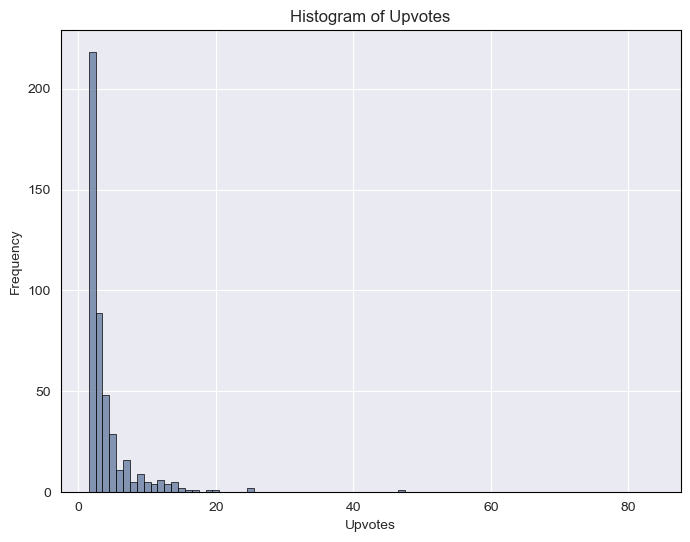

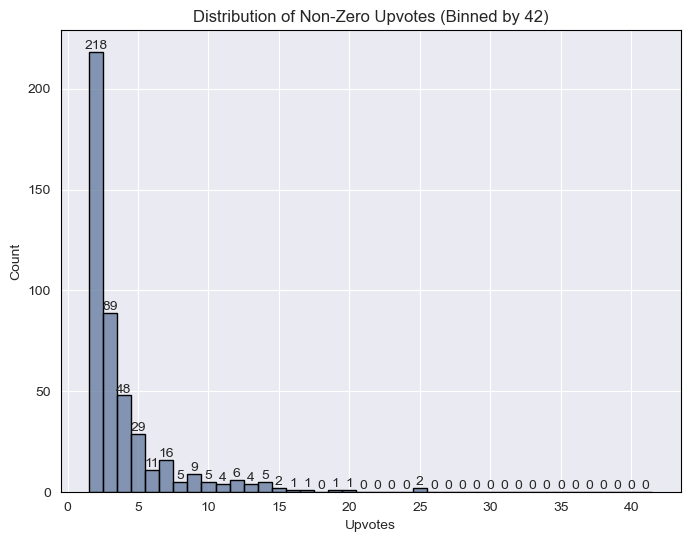

ID: 3381
Comment: For those curious, this is a .14 ounce size. That's about it a third of the travel size, which is .45 ounces and $15. So, a value of less than $5. I appreciate the gift, just wanted people to know what the actual size is. I should have just gotten the Lancôme mask online.
Number of Upvotes: 84

ID: 3374
Comment: So this is a comically small amount of product. I wish I would have chosen the mask. Photo is extremely misleading.
Number of Upvotes: 47

ID: 1518
Comment: I was struggling with random breakouts and a weird redness that would only be around my nostrils. I found that every time I wore makeup I broke out the next day. I was using the daily microfolient, the original and I thought I would give this a try. And when I did I shiz you not, any problem I was having with my skin disappeared within a couple of uses. I no longer break out after wearing my makeup and the redness around my nostrils is gone! I use this product every day. I highly recommend!
Number of Upvot

In [54]:
# upvotes
df["Review_Upvotes"] = df["Review_Upvotes"].astype(int)
# calculate summary statistics
stats = df['Review_Upvotes'].describe()

# format table
table = []
for key, value in stats.items():
    table.append([key.capitalize(), value])

# print table
print(tabulate(table, headers=['Statistic', 'Value'], tablefmt='pipe'))

# Assess potential outliers 

# calculate the z-score
mean = np.mean(df['Review_Upvotes'])
std = np.std(df['Review_Upvotes'])
z_score = (df['Review_Upvotes'] - mean) / std

# identify outliers
outliers = df['Review_Upvotes'][z_score > 3]
outliers_sorted = outliers.sort_values(ascending=True)
print(outliers_sorted)


# standardize the data using Z-score scaling
mean = np.mean(df['Review_Upvotes'])
std = np.std(df['Review_Upvotes'])
df['Review_Upvotes_zscore'] = (df['Review_Upvotes'] - mean) / std

# identify outliers using the standardized data
outliers = df['Review_Upvotes'][df['Review_Upvotes_zscore'] > 3]

# print the outliers in ascending order
outliers_sorted = outliers.sort_values(ascending=True)
print(outliers_sorted)
print(len(outliers_sorted))


# histogram of upvotes
# convert 'Review_Upvotes' column to string type
df['Review_Upvotes'] = df['Review_Upvotes'].astype(str)

# create a new column 'upvotes' by extracting the upvotes count using regex
df['upvotes'] = df['Review_Upvotes'].str.extract(r'^(\d+)')

# convert to numeric data type
df['upvotes'] = pd.to_numeric(df['upvotes'])

# Show distribution of upvotes
sns.histplot(df['upvotes'], kde=False, bins=[i+0.5 for i in range(1,84)], edgecolor='black')

# Set the axis labels and title
#plt.hist(upvotes,bins=[i+0.5 for i in range(1,13)])
plt.xlabel('Upvotes')
plt.ylabel('Frequency')
plt.title('Histogram of Upvotes')
plt.show()


# Histogram non-zero upvotes
df_no_zeros = df[df['upvotes'] != 0]

# Show distribution of non-zero downvotes
ax = sns.histplot(df_no_zeros['upvotes'], kde=False, bins=[i+0.5 for i in range(1,42)], edgecolor='black')

# Set the axis labels and title
plt.xlabel('Upvotes')
plt.ylabel('Count')
plt.title('Distribution of Non-Zero Upvotes (Binned by 42)')

# Add labels to each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')
plt.show()


# Assess reviews with most upvotes

# change to int for sorting
df["Review_Upvotes"] = df["Review_Upvotes"].astype(int)

# comments with highest upvotes 

# sort df by number of upvotes
sorted_df = df.sort_values(by='upvotes', ascending=False)

# get the first 10 comments with the most upvotes
top_comments = sorted_df.head(10)

# print the ID, comment, and number of upvotes for each top comment
for index, row in top_comments.iterrows():
    print(f"ID: {row['ID']}\nComment: {row['Review_Text']}\nNumber of Upvotes: {row['upvotes']}\n")


# Assess top upvoted comments by product
# group df by product
grouped_df = df.groupby('Product')

# Loop through each group and get the top 3 comments
for name, group in grouped_df:
    print(f"Product: {name}")
    top_comments = group.sort_values(by='Review_Upvotes', ascending=False).head(3)
    for index, row in top_comments.iterrows():
        print(f"ID: {row['ID']}\nComment: {row['Review_Text']}\nNumber of Upvotes: {row['Review_Upvotes']}\n")


max_upvotes_index = df["Review_Upvotes"].idxmax()
print(df.loc[max_upvotes_index, "Review_Text"])

In [73]:
# Define a function for extracting bigrams 

def get_bigrams(text):
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)
    
    # Create bigrams from the words
    bigrams = []
    for i in range(len(tokens) - 1):
        bigram = (tokens[i], tokens[i+1])
        bigrams.append(bigram)
        
    # Count the frequency of each bigram
    bigram_counts = Counter(bigrams)
    
    return bigram_counts



In [72]:

# Assess bigrams of all upvoted reviews

# filter the dataframe to only include rows with non-zero Review_Downvotes values
filtered_upvotes = df.loc[df['Review_Upvotes'] != 0]

# sort the filtered DataFrame by number of votes
sorted_upvotes = filtered_upvotes.sort_values(by='Review_Upvotes', ascending=False)

# Concatenate the top comments into a single string
top_comments_upvotes = ' '.join(sorted_upvotes['clean_review_text'].tolist())

# Call get_bigrams to get the Counter object of bigrams
bigram_upvotes = get_bigrams(top_comments_upvotes)

# Get the top 10 bigrams using the most_common method
top_bigram_upvotes= bigram_upvotes.most_common(15)

# Loop through the top bigrams and print them
for bigram, count in top_bigram_upvotes:
    print(bigram, count)
# add 'face' and 'leaves' to stopwords



('every', 'day') 69
('essential', 'cleansing') 58
('cleansing', 'solution') 58
('feel', 'like') 53
('time', 'week') 49
('leaf', 'feeling') 41
('make', 'feel') 41
('highly', 'recommend') 36
('long', 'time') 32
('long', 'way') 31
('soft', 'smooth') 31
('travel', 'size') 30
('gentle', 'enough') 29
('go', 'long') 28
('acne', 'prone') 27


In [74]:

# Asess bigrams of all downvoted reviews

# filter the dataframe to only include rows with non-zero Review_Downvotes values
filtered_upvotes = df.loc[df['Review_Downvotes'] != 0]

# sort the filtered DataFrame by number of votes
sorted_upvotes = filtered_upvotes.sort_values(by='Review_Downvotes', ascending=False)

# Concatenate the top comments into a single string
top_comments_upvotes = ' '.join(sorted_upvotes['clean_review_text'].tolist())

# Call get_bigrams to get the Counter object of bigrams
bigram_upvotes = get_bigrams(top_comments_upvotes)

# Get the top 10 bigrams using the most_common method
top_bigram_upvotes= bigram_upvotes.most_common(15)
       
        
# Loop through the top bigrams and print them
for bigram, count in top_bigram_upvotes:
    print(bigram, count)



('feel', 'like') 20
('every', 'day') 19
('essential', 'cleansing') 17
('cleansing', 'solution') 17
('time', 'week') 16
('leaf', 'feeling') 12
('travel', 'size') 10
('long', 'way') 10
('love', 'love') 10
('acne', 'prone') 9
('smell', 'like') 9
('long', 'time') 9
('little', 'go') 9
('go', 'long') 9
('highly', 'recommend') 8


In [75]:
# Top bigrams of review_text per product

# Define a function to get the top 15 bigrams for a given DataFrame
def get_top_bigrams(df):
    # Concatenate the top comments into a single string
    comments = ' '.join(df['clean_review_text'].tolist())

    # Call get_bigrams to get the Counter object of bigrams
    bigram_counter = get_bigrams(comments)

    # Get the top bigrams using the most_common method
    top_bigrams = bigram_counter.most_common(15)

    return top_bigrams

# Group the DataFrame by product and apply the get_top_bigrams function to each group
top_bigrams_by_product = df.groupby('Product').apply(get_top_bigrams)

# Loop through the top bigrams for each product and print them
for product, top_bigrams in top_bigrams_by_product.iteritems():
    print('\nProduct:', product)
    for bigram, count in top_bigrams:
        print(bigram, count)




AttributeError: 'Series' object has no attribute 'iteritems'